In [1]:
import torch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from torch.nn import Module, Linear, Sequential, Softplus
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

In [2]:
# Load the dataset. 
# molecule_features: First col is a string containing name of molecule. Rest are floats containing its features
# eutectic_compilation: First 2 cols are strings containing molecule names, third col is eutectic proportion, fourth is eutectic temperature

molecule_features = pd.read_csv("D:\\Research\\UConn_ML\\data\\eutectic_mixtures-main\\single_components.csv").drop(["xlogp"], axis=1)
eutectic_compilation = pd.read_csv("D:\\Research\\UConn_ML\\data\\eutectic_mixtures-main\\eutectic_compilation.csv")

molecule_features[molecule_features.columns[1:]] = molecule_features[molecule_features.columns[1:]].astype(float)
eutectic_compilation[eutectic_compilation.columns[3]] = eutectic_compilation[eutectic_compilation.columns[3]].astype(float)

In [3]:
# Some indices in eutectic_compilation do not exist in single_components. They will need to be removed.
# Some of the eutectic proportions are inconvertible to floats from strings. They will also need to be removed.
# missing_molecules will store all molecules that are missing features from eutectic_compilation
drops = np.array([]).astype(int)
missing_molecules = np.array([]).astype(str)
for i in range(len(eutectic_compilation)):
    ec = eutectic_compilation.iloc[i]
    m1 = ec[0]
    m2 = ec[1]
    xe = ec[2]
    
    m1f = molecule_features.loc[molecule_features.mol == ec[0]]
    m2f = molecule_features.loc[molecule_features.mol == ec[1]]
    
    try:
        xe = float(xe)
    except ValueError:
        drops = np.append(drops, i)
    
    if(len(m1f) == 0 or len(m2f) == 0):
        drops = np.append(drops, i)
        
        if(len(m1f) == 0):
            missing_molecules = np.append(missing_molecules, m1)
        elif(len(m2f) == 0):
            missing_molecules = np.append(missing_molecules, m2)

eutectic_compilation = eutectic_compilation.drop(eutectic_compilation.index[drops])
# np.savetxt("missing_molecules.csv", missing_molecules, delimiter=",", fmt="%s")

In [4]:
# Split the eutectic compilation dataframe by a ratio into training and testing sets
split = 0.85
train_ec = eutectic_compilation.sample(frac=split)
test_ec = eutectic_compilation.drop(train_ec.index)

In [5]:
molecule_features

,mol,molecular_weight,complexity,rotatable_bond_count,heavy_atom_count,topological_area
0,BaO,153.3300,2.0,0.0,2.0,17.1
1,CrCl3,158.3500,0.0,0.0,4.0,0.0
2,PBr5,430.4900,37.1,0.0,6.0,0.0
3,WCl5,361.1000,37.1,0.0,6.0,0.0
4,HgI2,454.4000,2.8,0.0,3.0,0.0
...,...,...,...,...,...,...
672,PBr3,270.6900,8.0,0.0,4.0,0.0
673,PbSiO3,283.0000,18.8,0.0,5.0,63.2
674,LiI,133.9000,2.0,0.0,2.0,0.0
675,EuF3,208.9590,8.0,0.0,4.0,0.0


In [6]:
train_ec

,molA,molB,xe,Te
321,AlBr3,BiBr3,34.4,137.3
2015,K2MoO4,Li2MoO4,32.5,513.0
2287,CsI,RbI,65,566.0
312,CsC2H3O2,LiNO3,85.1,135.0
75,AlBr3,AsBr3,26,25.5
...,...,...,...,...
3899,CaF2,CaSO4,50,951.0
3128,KBO2,LiCl,73,702.0
2070,CaCl2,YCl3,50,527.0
319,InCl,ZnCl2,55,137.0


In [7]:
test_ec

,molA,molB,xe,Te
5,BF3,SO2,38,-97.1
7,PCl3,TeCl4,100,-91.0
10,VCl4,VOCl3,27.8,-86.5
23,AsBr3,S2Br2,13.5,-56.0
30,Si2OCl6,TiCl4,42,-50.0
...,...,...,...,...
4449,SrO,ZrO2,27,2270.0
4451,Cr2O3,MgO,40,2290.0
4455,Y2O3,ZrO2,76,2330.0
4463,Sc2O3,ZrO2,52.2,2450.0


In [8]:
print(molecule_features.columns)
print(eutectic_compilation.columns)

Index(['mol', 'molecular_weight', 'complexity', 'rotatable_bond_count',
       'heavy_atom_count', 'topological_area'],
      dtype='object')
Index(['molA', 'molB', 'xe', 'Te'], dtype='object')


In [9]:
print(molecule_features.dtypes)
print(eutectic_compilation.dtypes)

mol                      object
molecular_weight        float64
complexity              float64
rotatable_bond_count    float64
heavy_atom_count        float64
topological_area        float64
dtype: object
molA     object
molB     object
xe       object
Te      float64
dtype: object


In [10]:
molecule_features.iloc[0]

mol                        BaO
molecular_weight        153.33
complexity                 2.0
rotatable_bond_count       0.0
heavy_atom_count           2.0
topological_area          17.1
Name: 0, dtype: object

In [11]:
print("Train Size: ", len(train_ec))
print("Test Size: ", len(test_ec))

Train Size:  3383
Test Size:  597


In [12]:
# SNN class with model
class SiameseNeuralNetwork(Module):
    def __init__(self, start_features):
        super(SiameseNeuralNetwork, self).__init__()
        
        self.fc = Linear(in_features=15, out_features=1) # final stage where prediction is made
        
        self.model = Sequential(
            Linear(in_features=start_features, out_features=20),
            Softplus(),
            Linear(in_features=20, out_features=30),
            Softplus(),
            Linear(in_features=30, out_features=15), # create the feature vectors
            Softplus()
        )

    def forward(self, x1, x2):
        y1 = self.model(x1)                
        y2 = self.model(x2)   
        d = y1 - y2                      # difference for xe
        # d = torch.abs(y1 - y2)           # difference for Te
        p = torch.sigmoid(self.fc(d))
        return p

In [13]:
# implementing f(A,B) = 1 - f(B,A)
# Currently this code throws an error, so I have left it out here. It seems I cannot change the weights in the forward function
# Will need to figure out another way to change the weights to maintain property. 
# for param in self.model.state_dict():
#     if(param == "4.weight"):
#         params = self.model.state_dict()[param]
#         self.model.state_dict()[param].copy_(-1 * params[0])

In [14]:
class MakeDataset(Dataset):
    def __init__(self, ec_df, mf_df, num_features):
        self.ecdf = ec_df
        self.mfdf = mf_df
        self.nf = num_features

    def __len__(self):
        return len(self.ecdf)
  
    def __getitem__(self, idx):
        ec = self.ecdf.iloc[idx]
        
        m1f = torch.tensor(np.array(self.mfdf.loc[self.mfdf.mol == ec[0]])[0][1:self.nf+1].astype(float))
        m2f = torch.tensor(np.array(self.mfdf.loc[self.mfdf.mol == ec[1]])[0][1:self.nf+1].astype(float))
        xe = torch.tensor(float(ec[2]))
        Te = torch.tensor(ec[3])
        
        return m1f, m2f, xe, Te

In [15]:
# define parameters for training
starting_features = 5
batchsize = 20

train_dset = MakeDataset(train_ec, molecule_features, starting_features)
test_dset = MakeDataset(test_ec, molecule_features, starting_features)

Epoch 1 | Train Loss: 32.66 | Baseline: 11.35
Epoch 2 | Train Loss: 32.052 | Baseline: 11.361
Epoch 3 | Train Loss: 31.132 | Baseline: 11.42
Epoch 4 | Train Loss: 30.46 | Baseline: 11.404
Epoch 5 | Train Loss: 29.225 | Baseline: 11.381
Epoch 6 | Train Loss: 28.287 | Baseline: 11.364
Epoch 7 | Train Loss: 27.556 | Baseline: 11.465
Epoch 8 | Train Loss: 26.288 | Baseline: 11.355
Epoch 9 | Train Loss: 25.219 | Baseline: 11.35
Epoch 10 | Train Loss: 24.162 | Baseline: 11.411
Epoch 11 | Train Loss: 23.235 | Baseline: 11.387
Epoch 12 | Train Loss: 22.215 | Baseline: 11.377
Epoch 13 | Train Loss: 21.398 | Baseline: 11.399
Epoch 14 | Train Loss: 20.786 | Baseline: 11.463
Epoch 15 | Train Loss: 19.721 | Baseline: 11.369
Epoch 16 | Train Loss: 19.021 | Baseline: 11.402
Epoch 17 | Train Loss: 18.367 | Baseline: 11.359
Epoch 18 | Train Loss: 17.884 | Baseline: 11.417
Epoch 19 | Train Loss: 17.296 | Baseline: 11.355
Epoch 20 | Train Loss: 16.957 | Baseline: 11.385
Epoch 21 | Train Loss: 16.511 | Ba

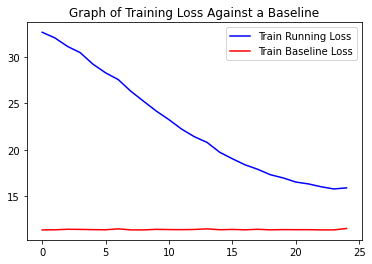

Test Loss: 2.717 | Baseline: 2.022



In [16]:
train_ec_dl = DataLoader(train_dset, shuffle=True, batch_size=batchsize)
test_ec_dl = DataLoader(test_dset, shuffle=True, batch_size=batchsize)

# Set the model and training parameters
model = SiameseNeuralNetwork(starting_features)
num_epochs = 25
learn_rate = 1.25e-6

# Set optimizer and loss function. Using MSE for regression.
opt = torch.optim.Adam(model.parameters(), lr=learn_rate)
criterion = torch.nn.MSELoss()
base_xe = torch.mean(torch.tensor(np.array(eutectic_compilation["xe"]).astype(float)) / 100.0)

###################################### Training ######################################
trloss = np.array([])
trbase = np.array([])
model.train()
for epoch in range(num_epochs):
    train_running_loss = 0.0
    train_base_loss = 0.0
    train_accuracy = 0.0

    # training step: iterate through the batch and obtain the 4 data
    for x, (m1, m2, xe, Te) in enumerate(train_ec_dl):   
        opt.zero_grad()
        xe = xe/100.0
        # pass 2 sets of inputs into the snn and gives p, the output
        output = model(m1.float(), m2.float())
        loss = criterion(output[:, 0], xe)
        
        base = torch.full((len(xe),), base_xe)
        base_loss = criterion(base, xe)

        loss.backward()
        opt.step()

        train_running_loss += loss.item()
        train_base_loss += base_loss.item()

    print('Epoch {} | Train Loss: {} | Baseline: {}'.format(epoch+1, np.round(train_running_loss, 3), np.round(train_base_loss, 3)))
    trloss = np.append(trloss, train_running_loss)
    trbase = np.append(trbase, train_base_loss)

plt.figure(1)
x = np.arange(num_epochs)
plt.plot(x, trloss, label="Train Running Loss", c="blue")
plt.plot(x, trbase, label="Train Baseline Loss", c="red")
plt.title("Graph of Training Loss Against a Baseline")
plt.legend(loc="upper right")
plt.show()

###################################### Testing ###################################### 
test_loss = 0.0
test_baseline = 0.0
model.eval()
with torch.no_grad():
    for (m1, m2, xe, Te) in test_ec_dl:
        xe = xe/100.0
        outputs = model(m1.float(), m2.float())
        test_loss += criterion(outputs[:, 0], xe).item()

        base = torch.full((len(xe),), base_xe)
        test_baseline += criterion(base, xe).item()

    print('Test Loss: {} | Baseline: {}\n'.format(np.round(test_loss, 3), np.round(test_baseline, 3)))

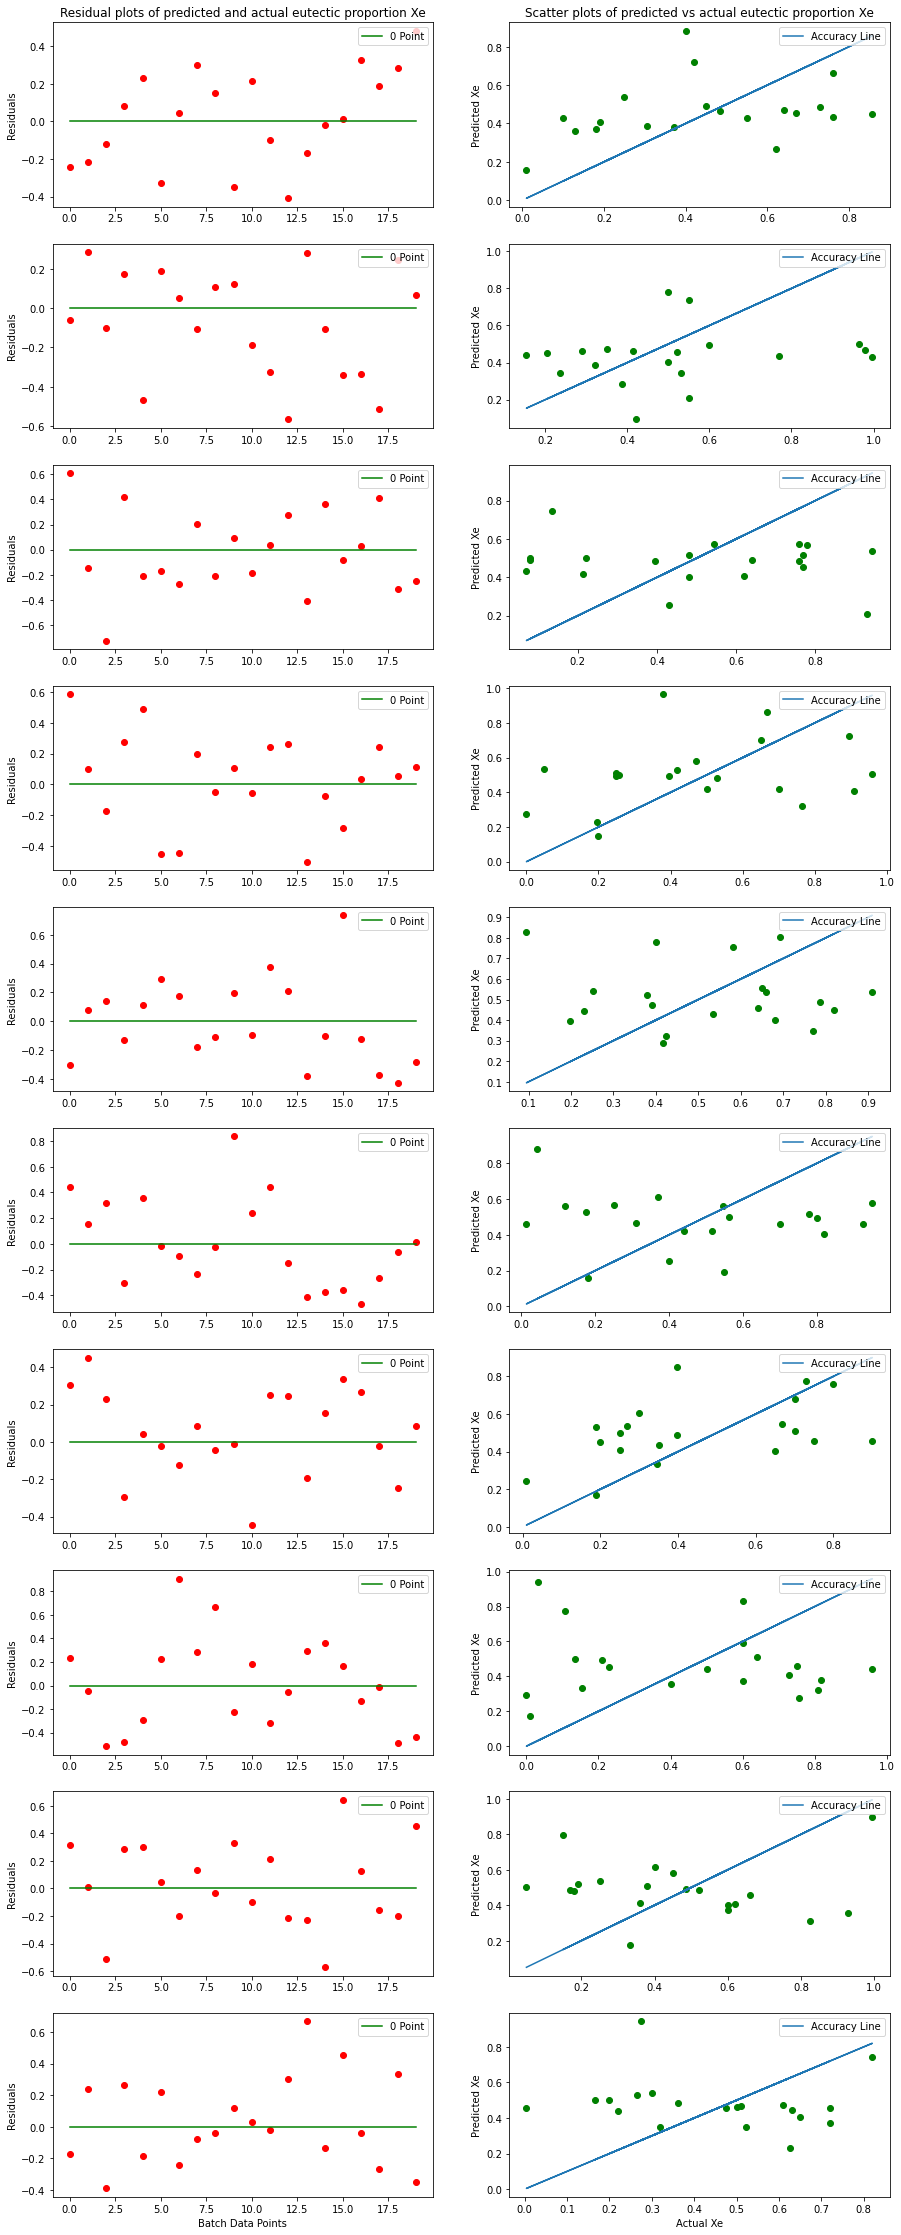

Original Values:  tensor([0.5220, 0.3000, 0.6250, 0.2650, 0.6300, 0.2200, 0.6500, 0.8200, 0.5000,
        0.3610, 0.3200, 0.4750, 0.2000, 0.2750, 0.6100, 0.0040, 0.5100, 0.7200,
        0.1650, 0.7200])
Predicted Values:  tensor([0.3521, 0.5417, 0.2337, 0.5306, 0.4448, 0.4390, 0.4081, 0.7433, 0.4598,
        0.4825, 0.3517, 0.4547, 0.5012, 0.9458, 0.4718, 0.4571, 0.4700, 0.4546,
        0.5020, 0.3701])


In [17]:
################################ Plotting ################################
# Take 10 random batches and plot the values in it
with torch.no_grad():
    fig, axes = plt.subplots(10, 2)
    fig.set_figheight(40)
    fig.set_figwidth(15)
    row = 0
    col = 0
    for (m1, m2, xe, Te) in test_ec_dl:
        xe = xe/100.0
        outputs = model(m1.float(), m2.float())

        x = np.arange(len(xe))
        
        axes[row, col].scatter(x, outputs.detach().numpy() - xe[np.newaxis].numpy().T, c="red")
        axes[row, col].plot(x, np.zeros((len(xe),)), c="green", label="0 Point")
        axes[row, 0].set(ylabel="Residuals")
        axes[row, col].legend(loc="upper right")

        axes[row, col+1].scatter(xe.numpy(), outputs.detach().numpy(), c="green")
        axes[row, col+1].plot(xe.numpy(), xe.numpy(), label="Accuracy Line")
        axes[row, 1].set(ylabel="Predicted Xe")
        axes[row, col+1].legend(loc="upper right")
        
        row += 1
        if row == 10:
            break

    axes[-1, 0].set(xlabel="Batch Data Points")
    axes[-1, 1].set(xlabel="Actual Xe")
    axes[0, 0].set_title("Residual plots of predicted and actual eutectic proportion Xe")
    axes[0, 1].set_title("Scatter plots of predicted vs actual eutectic proportion Xe")
    plt.show()
    
    print("Original Values: ", xe)
    print("Predicted Values: ", outputs.flatten())

In [18]:
# fig.savefig('D:\\Research\\UConn_ML\\Images\\snn_results_plots.png')